In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
seg_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
seg_model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 170MB/s]  


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [4]:
#Not helpful
"""
#Trying from segmentation_model_pytorch
#!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
seg_model = smp.Unet('resnet34', encoder_weights='imagenet')
seg_model.eval()
"""

"\n#Trying from segmentation_model_pytorch\n#!pip install segmentation_models_pytorch\nimport segmentation_models_pytorch as smp\nseg_model = smp.Unet('resnet34', encoder_weights='imagenet')\nseg_model.eval()\n"

In [5]:
def gen_seg(img_path,model):
    imgg=Image.open(img_path)
    img=imgg.convert("RGB")
    pre=transforms.Compose([
        #transforms.Resize(256,256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img=pre(img).unsqueeze(0)
    outputs=model(img)
    """for smp
    with torch.no_grad():
        #outputs=model(img)
        outputs=model.predict(img)
    outputs=outputs.cpu().numpy()
    outputs=np.transpose(outputs,(2,3,1,0))
    outputs=np.squeeze(outputs)
    """
    with torch.no_grad():
        outputs=model(img)['out'][0]
    pred=outputs.cpu().argmax(0)
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    r = Image.fromarray(pred.byte().cpu().numpy()).resize(imgg.size)
    r.putpalette(colors)
    plt.imshow(r)
    #plt.imshow(outputs)
    return pred

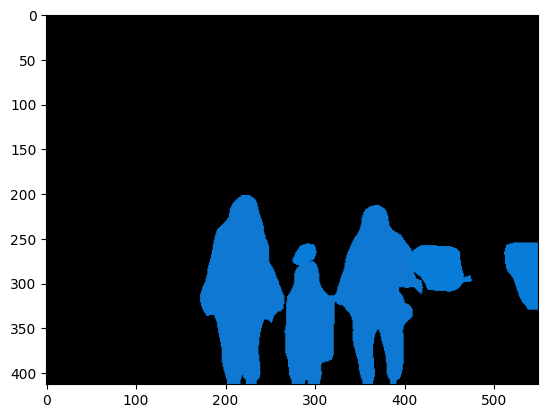

In [6]:
trail=gen_seg('/kaggle/input/dataset-of-dehazing/clear/c469.jpg',seg_model)

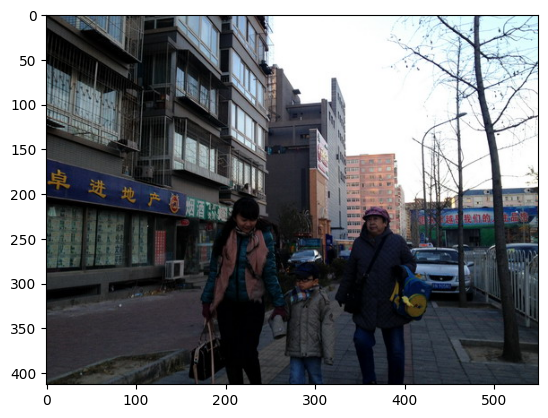

In [7]:
im=Image.open('/kaggle/input/dataset-of-dehazing/clear/c469.jpg')
im=np.array(im)
plt.imshow(im)

In [8]:
def gen_seg_folder(img_path,model,outputfolder,filename):
    imgg=Image.open(img_path)
    img=imgg.convert('RGB')
    pre=transforms.Compose([
        #transforms.Resize(256,256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img=pre(img).unsqueeze(0)
    outputs=model(img)
    """for smp
    with torch.no_grad():
        #outputs=model(img)
        outputs=model.predict(img)
    outputs=outputs.cpu().numpy()
    outputs=np.transpose(outputs,(2,3,1,0))
    outputs=np.squeeze(outputs)
    """
    with torch.no_grad():
        outputs=model(img)['out'][0]
    pred=outputs.cpu().argmax(0)
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    r = Image.fromarray(pred.byte().cpu().numpy()).resize(imgg.size)
    r.putpalette(colors)
    path=os.path.join(outputfolder,filename)
    r.save(path)
    #plt.imshow(outputs)
    return pred

In [9]:
os.makedirs('seg')

In [10]:
path_dehazed=os.listdir('/kaggle/input/dataset-of-dehazing/clear')
for l in path_dehazed:
    filename, extension = os.path.splitext(l)
    if extension.lower() == '.jpg':
        new_filename = filename + '.png'
        gen_seg_folder('/kaggle/input/dataset-of-dehazing/clear/'+l,seg_model,'/kaggle/working/seg',new_filename)

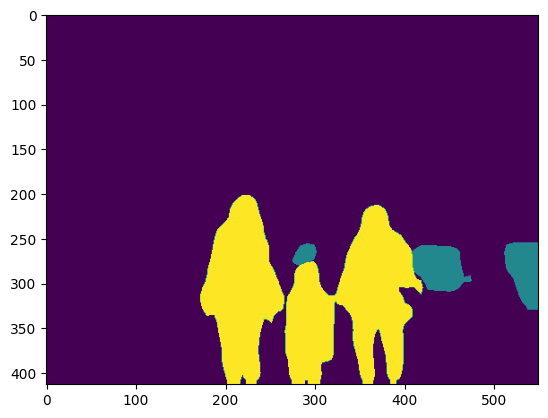

In [11]:
im=Image.open('/kaggle/working/seg/c469.png')
im=np.array(im)
plt.imshow(im)

In [64]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import torch.optim as optim

In [65]:
class ResBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return nn.ReLU(True)(out)

In [66]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Up, self).__init__()
        self.up = nn.Sequential(
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.Conv2d(in_ch, out_ch,
            #           kernel_size=3, stride=1,
            #           padding=1, bias=use_bias),
            nn.ConvTranspose2d(in_ch, out_ch,
                               kernel_size=3, stride=2,
                               padding=1, output_padding=1,
                               bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [67]:
class Outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Outconv, self).__init__()
        self.outconv = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, out_ch, kernel_size=7, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.outconv(x)
        return x

In [68]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3,
                      stride=2, padding=1, bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.down(x)
        return x

In [69]:
class Inconv(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Inconv, self).__init__()
        self.inconv = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, out_ch, kernel_size=7, padding=0,
                      bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.inconv(x)
        return x

In [70]:
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=9, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.inc = Inconv(input_nc, ngf, norm_layer, use_bias)
        self.down1 = Down(ngf, ngf * 2, norm_layer, use_bias)
        self.down2 = Down(ngf * 2, ngf * 4, norm_layer, use_bias)

        model = []
        for i in range(n_blocks):
            model += [ResBlock(ngf * 4, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        self.resblocks = nn.Sequential(*model)

        self.up1 = Up(ngf * 4, ngf * 2, norm_layer, use_bias)
        self.up2 = Up(ngf * 2, ngf, norm_layer, use_bias)

        self.outc = Outconv(ngf, output_nc)

    def forward(self, input):
        out = {}
        out['in'] = self.inc(input)
        out['d1'] = self.down1(out['in'])
        out['d2'] = self.down2(out['d1'])
        out['bottle'] = self.resblocks(out['d2'])
        out['u1'] = self.up1(out['bottle'])
        out['u2'] = self.up2(out['u1'])

        return self.outc(out['u2'])

In [71]:
def define_G(input_nc, output_nc, ngf, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
   
    return init_net(net, init_type, init_gain, gpu_id)

In [72]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

In [73]:
def define_D(input_nc, ndf, netD,
             n_layers_D=3, norm='batch', use_sigmoid=False, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    elif netD == 'n_layers':
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    elif netD == 'pixel':
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % net)

    return init_net(net, init_type, init_gain, gpu_id)

In [74]:
def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'switchable':
        norm_layer = SwitchNorm2d
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

In [75]:
def get_scheduler(optimizer, opt):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.niter, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler

In [76]:
def update_learning_rate(scheduler, optimizer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)


def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)


def init_net(net, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net.to(gpu_id)
    init_weights(net, init_type, gain=init_gain)
    return net

In [77]:
G=define_G(3,3,64)

initialize network with normal


In [78]:
G

ResnetGenerator(
  (inc): Inconv(
    (inconv): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (down): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down2): Down(
    (down): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (resblocks): Sequential(
    (0): ResBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3)

In [91]:
imgg=Image.open('/kaggle/input/dataset-of-dehazing/clear/c469.jpg')
img=imgg.convert("RGB")
pre=transforms.Compose([
    #transforms.Resize(256,256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img=pre(img).unsqueeze(0)
img=img.to('cuda')
with torch.no_grad():
    outputs=G(img)

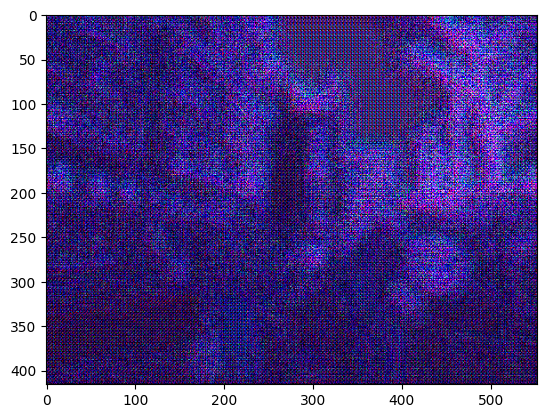

In [92]:
G_t=outputs.cpu().numpy()
G_t=np.transpose(G_t,(2,3,1,0))
G_t=np.squeeze(G_t)
plt.imshow(G_t)

In [93]:
D=define_D(3,64,'basic')

initialize network with normal


In [94]:
D

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [95]:
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

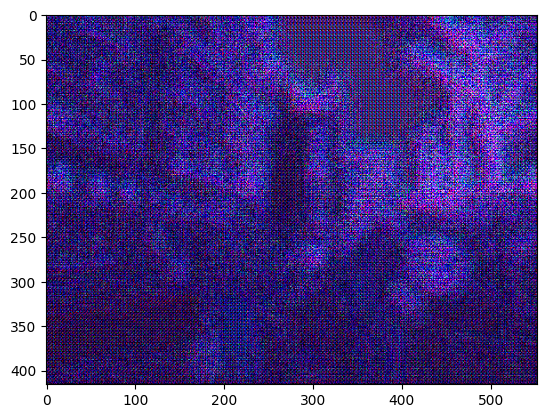

In [96]:
with torch.no_grad():
    D_outputs=D(img)
D_t=outputs.cpu().numpy()
D_t=np.transpose(D_t,(2,3,1,0))
D_t=np.squeeze(D_t)
plt.imshow(D_t)

In [105]:
vgg_model=models.vgg16(weights='IMAGENET1K_V1')
vgg_model.eval()
vgg_model=vgg_model.to('cuda')

OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 52.12 MiB is free. Process 2227 has 15.84 GiB memory in use. Of the allocated memory 14.78 GiB is allocated by PyTorch, and 794.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [102]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [103]:
from torchvision.models.feature_extraction import create_feature_extractor

In [104]:
return_nodes = {
    "features.16": "features"
}
vgg_extract = create_feature_extractor(vgg_model, return_nodes=return_nodes)
vgg_extract.eval()
with torch.no_grad():
    i_o = vgg_extract(img)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [37]:
i_o_n=i_o['features'].cpu().numpy()
print(i_o_n.shape)

(1, 256, 51, 68)


In [38]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset, DataLoader

In [39]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to the same size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [40]:
class CustomDataset(Dataset):
    def __init__(self, root_dir_dehazed, root_dir_hazed, root_dir_segmented, transform=None):
        self.root_dir_dehazed = root_dir_dehazed
        self.root_dir_hazed = root_dir_hazed
        self.root_dir_segmented = root_dir_segmented
        self.transform = transform
        self.dehazed_images = os.listdir(root_dir_dehazed)
        self.hazed_images = os.listdir(root_dir_hazed)
        self.segmented_images = os.listdir(root_dir_segmented)

    def __len__(self):
        return min(len(self.dehazed_images), len(self.hazed_images), len(self.segmented_images))

    def __getitem__(self, idx):
        dehazed_img_name = os.path.join(self.root_dir_dehazed, self.dehazed_images[idx])
        hazed_img_name = os.path.join(self.root_dir_hazed, self.hazed_images[idx])
        segmented_img_name = os.path.join(self.root_dir_segmented, self.segmented_images[idx])

        dehazed_image = Image.open(dehazed_img_name).convert('RGB')
        hazed_image = Image.open(hazed_img_name).convert('RGB')
        segmented_image = Image.open(segmented_img_name).convert('RGB')

        if self.transform:
            dehazed_image = self.transform(dehazed_image)
            hazed_image = self.transform(hazed_image)
            segmented_image = self.transform(segmented_image)

        return dehazed_image, hazed_image, segmented_image

In [41]:
dehazed_folder = '/kaggle/input/dataset-of-dehazing/clear'
hazed_folder = '/kaggle/input/dataset-of-dehazing/haze'
segmented_folder = '/kaggle/working/seg'

In [42]:
custom_dataset = CustomDataset(root_dir_dehazed=dehazed_folder, 
                                root_dir_hazed=hazed_folder, 
                                root_dir_segmented=segmented_folder, 
                                transform=transform)

In [55]:
batch_size = 16
train_size = int(0.8 * len(custom_dataset))
val_size = int(0.1 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

In [56]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [57]:
criterionGAN = GANLoss()
criterionL1 = nn.L1Loss()
criterionMSE = nn.MSELoss()

In [58]:
optimizerG = optim.Adam(G.parameters(), lr=0.001, betas=(0.001, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=0.001, betas=(0.001, 0.999))

In [59]:
real_a = torch.FloatTensor(32, 3, 256, 256)
real_b = torch.FloatTensor(32, 3, 256, 256)
real_c = torch.FloatTensor(32, 3, 256, 256)

In [60]:
print(2+3)

5


In [61]:
"""
if torch.cuda==True:
    vgg_model=vgg_model.cuda()
    seg_net=seg_net.cuda()
    D = D.cuda()
    G = G.cuda()
    criterionGAN = criterionGAN.cuda()
    criterionL1 = criterionL1.cuda()
    criterionMSE = criterionMSE.cuda()
    real_a = real_a.cuda()
    real_b = real_b.cuda()
    real_c=real_c.cuda()
"""

In [62]:
num_epoch=5

In [63]:
torch.cuda.empty_cache()
for epoch in range(num_epoch):
    loss_epoch_gen=0
    loss_epoch_dis=0
    loss_seg=0
    for itr,batch in enumerate(train_loader,1):
        G.train()
        b_dehazed,b_hazed,b_segmented=batch[0],batch[1],batch[2]
        b_dehazed=b_dehazed.cuda()
        b_hazed=b_hazed.cuda()
        b_segmented=b_segmented.cuda()
        #Gen fake images
        fake_b=G(b_hazed)
        # (1) Update D network: maximize log(D(x,y)) + log(1 - D(x,G(x)))
        optimizerD.zero_grad()
        

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 56.12 MiB is free. Process 2227 has 15.84 GiB memory in use. Of the allocated memory 14.59 GiB is allocated by PyTorch, and 977.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [54]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 4            |        cudaMalloc retries: 4         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  14943 MiB |  14943 MiB |  29909 MiB |  14965 MiB |\n|       from large pool |  14941 MiB |  14941 MiB |  29903 MiB |  14962 MiB |\n|       from small pool |      2 MiB |      3 MiB |      5 MiB |      3 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  14943 MiB |  14943 MiB |  29909 MiB |  14965 MiB |\n|       from large pool |  14941 MiB |  14941 MiB |